In [1]:
import os
import json
import requests
import random
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from citipy import citipy

from config import WOM_API_KEY

class WeatherPy(object):
    
    _number_of_cities = None
    _cities_set = set()
    _cities_df = pd.DataFrame()
    _log_file = None
    _base_url = 'http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=' + WOM_API_KEY + '&q='
    _today = date.today().strftime('%m/%d/%y')
    
    @property
    def cities(self):
        return self._cities_df.reset_index()[[
            'City Name', 'Country Code', 'Date',
            'Latitude', 'Longitude',
            'Humidity', 'Max Temperature', 'Cloudiness', 'Wind Speed'
        ]]

    @property
    def number_of_cities(self):
        return self._number_of_cities
      
    def __init__(self, 
                 number_of_cities=None,
                 log_file=None):
        self._number_of_cities = number_of_cities or 4 # Default to 4 for testing
        if log_file:
            self._log_file = open(log_file, 'w')
        sns.set()
        sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
        
    def __del__(self):
        if self._log_file:
            self._log_file.close()

    def _pick_a_city(self, i):
        while True:
            lat, lon = (random.uniform(-90, 90), random.uniform(-180, 180))
            city = citipy.nearest_city(lat, lon)
            city_name = city.city_name
            country_code = city.country_code
            city_full = city_name + ',' + city.country_code

            self.log('Processing City # {} | {}'.format(i, city_full))

            # Check if city is already picked
            if city_full in self._cities_set:
                self.log('Skip duplicate {}'.format(city_full))
                continue
            
            # Check weather
            url = self._base_url + city_full
            self.log(url)
            response = requests.get(url)
            if response.status_code != 200:
                self.log('Weather not found for ' + city_full + '. Try another city.')
                continue

            w = response.json()
            #print(json.dumps(w, indent=2))
            self._cities_df = self._cities_df.append(
                pd.DataFrame([{
                        'City Name': city_name,
                        'Country Code': country_code,
                        'Date': self._today,
                        'Latitude': w['coord']['lat'],
                        'Longitude': w['coord']['lon'],
                        'Humidity': w['main']['humidity'],
                        'Max Temperature': w['main']['temp_max'],
                        'Wind Speed': w['wind']['speed'],
                        'Cloudiness': w['clouds']['all'],
                    }]
                )
            )

            self._cities_set.add(city_full)
            break
        
    def pick_all_cities(self):
        for i in range(self.number_of_cities):
            self._pick_a_city(i)
        
    def write_data_to_csv(self):
        self.cities.to_csv('weather_py.csv')
        
    def plot_lat_lon(self):
        fig, ax = plt.subplots(figsize=(10, 5))
        self.cities.plot.scatter('Longitude', 'Latitude', ax=ax)
            
        plt.xlim(-180, 180); plt.ylim(-90, 90)
        plt.show()
        
    def plot_weather(self):
        fig = plt.figure(figsize=(15,10))
        fig.suptitle("Correlation of City Latitude vs. Weather Metrics")

        for i, metric in [(1, 'Max Temperature'),
                          (2, 'Humidity'),
                          (3, 'Cloudiness'),
                          (4, 'Wind Speed')]:
            self.cities.plot.scatter(x='Latitude', y=metric, 
                                   title='City Latitude vs. {} ({})'.format(metric, self._today),
                                   ax=plt.subplot(2, 2, i),
                                   xlim=(-90, 90))                          

        fig.savefig('weather_py.png')
        plt.show()

    def log(self, msg):
        if self._log_file:
            self._log_file.write(msg + '\n')
            self._log_file.flush() # Easier to see progress in tail -f
        else:
            print(msg)

In [2]:
weather_py = WeatherPy(number_of_cities=500, log_file='weather_py.log')
weather_py.pick_all_cities()
weather_py.write_data_to_csv()

In [3]:
weather_py.cities.head()

,City Name,Country Code,Date,Latitude,Longitude,Humidity,Max Temperature,Cloudiness,Wind Speed
0,georgetown,sh,03/13/18,-7.93,-14.42,100,78.83,0,11.68
1,avarua,ck,03/13/18,-21.21,-159.78,94,78.80,90,3.36
2,atuona,pf,03/13/18,-9.80,-139.03,100,79.82,88,9.78
3,albany,au,03/13/18,-35.02,117.88,85,68.48,92,6.31
4,rikitea,pf,03/13/18,-23.12,-134.97,100,80.18,20,7.76


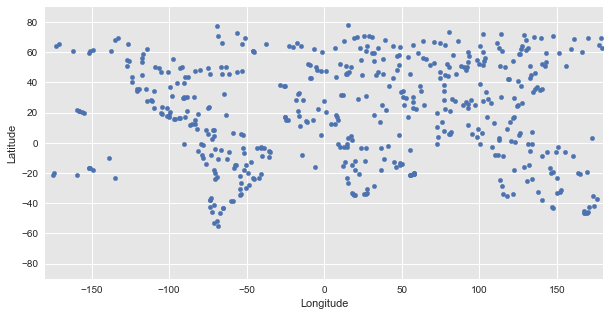

In [4]:
weather_py.plot_lat_lon()

This match the map of the world pretty well.

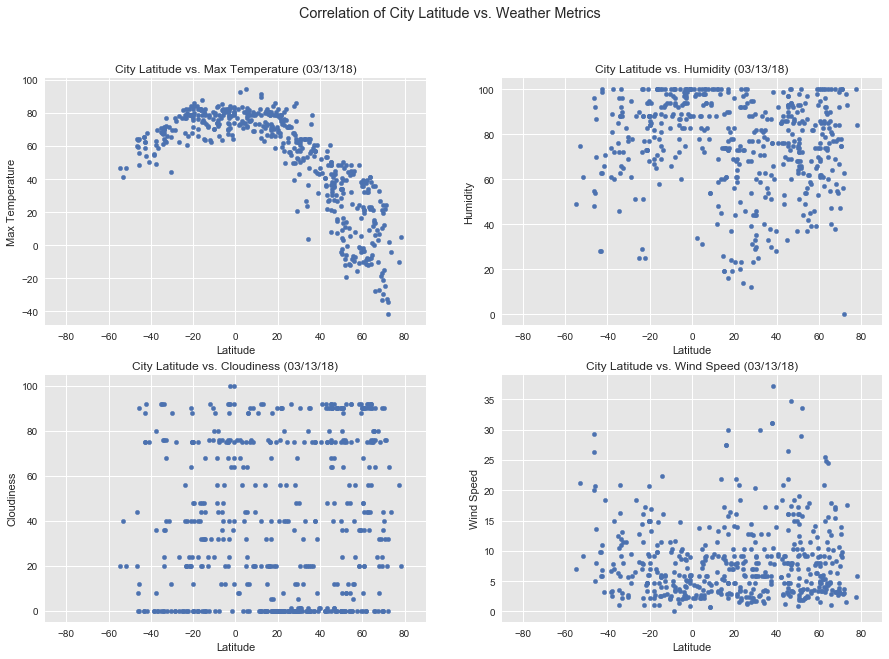

In [5]:
weather_py.plot_weather()

As observed, if using the original random latitude and longitude, there location on higer latitude will see biggest problem.

### Destruct object to clean up

In [6]:
del weather_py